In [1]:


from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import matplotlib.pyplot as plt 
import tensorflow_io as tfio
import tensorflow as tf


root = '../'
exts = ('jpg', 'JPG', 'png', 'PNG', 'tif', 'gif', 'ppm')

Segmentation Models: using `tf.keras` framework.


# DRIVE

The dataset comes with pair of input retina image and target mask. Among all retina image, we will only use this dataset for a quick baseline. However, rest of the dataset can be replaces easily on this pipeline.


In [2]:
input_data = os.path.join('../data/raw/training/input')
images = sorted(
    [
        os.path.join(input_data, fname)
        for fname in os.listdir(input_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)


target_data = os.path.join('../data/raw/training/target')
masks = sorted(
    [
        os.path.join(target_data, fname)
        for fname in os.listdir(target_data)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

print("Number of samples:", len(images), len(masks))
for input_path, target_path in zip(images[:10], masks[:10]):
    print(input_path[-31:], "|", target_path[-34:])

Number of samples: 20 20
/training/input/21_training.png | raw/training/target/21_manual1.png
/training/input/22_training.png | raw/training/target/22_manual1.png
/training/input/23_training.png | raw/training/target/23_manual1.png
/training/input/24_training.png | raw/training/target/24_manual1.png
/training/input/25_training.png | raw/training/target/25_manual1.png
/training/input/26_training.png | raw/training/target/26_manual1.png
/training/input/27_training.png | raw/training/target/27_manual1.png
/training/input/28_training.png | raw/training/target/28_manual1.png
/training/input/29_training.png | raw/training/target/29_manual1.png
/training/input/30_training.png | raw/training/target/30_manual1.png


In [3]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
EPOCHS = 4

def read_files(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        # Decodificar o arquivo PNG para o 'mask'
        image = tf.image.decode_png(image, channels=1) # out: (h, w, 1)
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.int32)  # ou tf.float32, dependendo da aplicação
    else:
        # Decodificar o arquivo PNG para a imagem de entrada
        image = tf.image.decode_png(image, channels=3) # out: (h, w, 3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255.0  # Normaliza os valores para a faixa [0, 1]
    return image


def load_data(image_list, mask_list):
    image = read_files(image_list)
    mask  = read_files(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset

train_dataset = data_generator(images, masks)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.int32, name=None))>

In [4]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images) 
    plt.figure(figsize=(20, 20))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()

(1, 512, 512, 3) (1, 512, 512, 1)
0 255
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 23

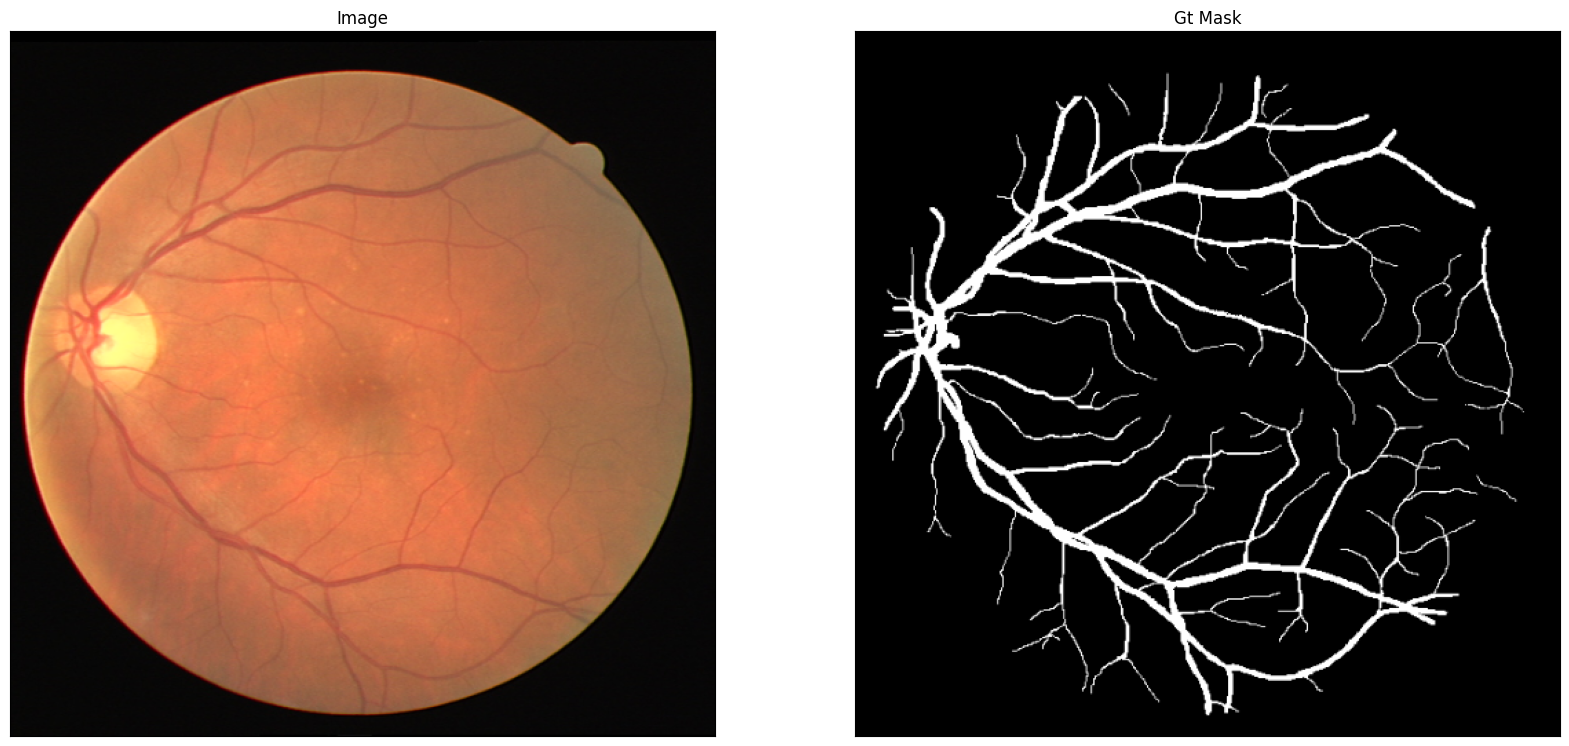

In [5]:
image, mask = next(iter(train_dataset.take(1))) 
print(image.shape, mask.shape)

for (img, msk) in zip(image[:5], mask[:5]):
    print(mask.numpy().min(), mask.numpy().max())
    print(np.unique(mask.numpy()))
    visualize(
        image=img.numpy(),
        gt_mask=msk.numpy(),
    )

In [6]:
from tensorflow import keras 

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
BACKBONE   = 'efficientnetb3'
n_classes  = 1 


# Callback : Monitoring Training Progress

In [7]:
import keras

In [8]:
class DisplayCallback(keras.callbacks.Callback):
    def __init__(self, dataset, epoch_interval=50):
        self.dataset = dataset
        self.epoch_interval = epoch_interval
    
    def display(self, display_list, extra_title=''):
        plt.figure(figsize=(15, 15))
        title = ['Input Image', 'True Mask', 'Predicted Mask']

        if len(display_list) > len(title):
            title.append(extra_title)

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i], cmap='gray')
            plt.axis('off')
        plt.show()
        
    def create_mask(self, pred_mask):
        pred_mask = (pred_mask > 0.5).astype("int32")
        return pred_mask[0]
    
    def show_predictions(self, dataset, num=1):
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            self.display([image[0], mask[0], self.create_mask(pred_mask)])
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch and epoch % self.epoch_interval == 0:
            self.show_predictions(self.dataset)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# Compile and Fit

In [9]:
# define optomizer
LR = 0.0001
optim = keras.optimizers.Adam(LR)
# Definir perda e métricas
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy', 'precision', 'recall']

In [10]:
import json
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from itertools import product

DATA_DIR = '../data/raw/'
PATH_MODELS = "../models/"
PATH_LOGS = "../logs/"
RESULTS_PATH = "../results/"

In [11]:
# Suponha que `dataset` seja o seu dataset original
def change_dtype(x, y):
    # x é a entrada e y é o rótulo/máscara
    y = tf.cast(y, tf.float32)  # Converte o tipo de dados de y para tf.float32
    return x, y

# Aplica a transformação ao dataset
train_dataset = train_dataset.map(change_dtype)

In [18]:
preprocessing_fn = sm.get_preprocessing(BACKBONE)

In [19]:
# Função para pré-processar imagens do dataset
def preprocess_dataset(image, mask):
    image = tf.cast(image, tf.float32)  # Converta para float32 se necessário
    image = preprocessing_fn(image)  # Aplique a função de pré-processamento
    return image, mask


# Aplique a pré-processamento a cada item do dataset
preprocessed_dataset = train_dataset.map(preprocess_dataset, num_parallel_calls=tf.data.AUTOTUNE)

# Agora você pode usar `preprocessed_dataset` para treinar seu modelo
# Exemplo:
# model.fit(preprocessed_dataset, epochs=10)


In [21]:
activation_list = [
    'sigmoid', 
    'softmax'
            ]
augmentation_list=[
    # False,
   True
    ]


for activation, augmentation in product(activation_list, augmentation_list):
    
    
    keras.backend.clear_session()
    
    model_name = f'model_{BACKBONE}_{activation}_aug={augmentation}'
    
    
    model_weights = PATH_MODELS + f'weights/best_{model_name}.weights.h5'
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10),
        ModelCheckpoint(PATH_MODELS + f'model_file/best_{model_name}.keras', save_best_only=True, monitor='val_loss'),
        ModelCheckpoint(model_weights, save_weights_only=True, save_best_only=True, mode='min'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
        TensorBoard(log_dir=PATH_LOGS),
        CSVLogger(PATH_MODELS + f'training_log_{model_name}.csv')
    ]
    
    
    valid_aug = None
    train_aug = None
    
    
    if augmentation:
        valid_aug = None
        train_aug = None
        
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
    # print(model.summary())
    
    # compile keras model with defined optimozer, loss and metrics
    model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

    history = model.fit(
        preprocessed_dataset, 
        # callbacks=[DisplayCallback(train_dataset)],
        callbacks=callbacks,
        epochs=EPOCHS
    )
    


    json.dump(history.history, open(RESULTS_PATH + f"history/history_{model_name}.json", "w"))

Epoch 1/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.7237 - f1-score: 1.4756 - iou_score: 5.2600 - loss: -30.4294 - precision: 0.3490 - recall: 0.7027 - learning_rate: 0.0010
Epoch 2/4


/home/semcovici/pesquisa/segmentation-of-blood-vessels-in-retinal-images/.venv/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,f1-score,iou_score,loss,precision,recall
  current = self.get_monitor_value(logs)
/home/semcovici/pesquisa/segmentation-of-blood-vessels-in-retinal-images/.venv/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/home/semcovici/pesquisa/segmentation-of-blood-vessels-in-retinal-images/.venv/lib/python3.11/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,f1-score,iou_score,loss,precision,recall,learning_rate.
  callback.on_epoch_end(epoch, logs

20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.7336 - f1-score: 1.8650 - iou_score: 15.2807 - loss: -131.6202 - precision: 0.4229 - recall: 0.9095 - learning_rate: 0.0010
Epoch 3/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.7115 - f1-score: 1.9008 - iou_score: 21.9147 - loss: -207.7790 - precision: 0.3971 - recall: 0.9386 - learning_rate: 0.0010
Epoch 4/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.6478 - f1-score: 1.9299 - iou_score: 29.6482 - loss: -239.6585 - precision: 0.3304 - recall: 0.9674 - learning_rate: 0.0010
Epoch 1/4


/home/semcovici/pesquisa/segmentation-of-blood-vessels-in-retinal-images/.venv/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 512, 512, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 7.1319e-04 - f1-score: 1.9100 - iou_score: 21.7622 - loss: -249.1591 - precision: 0.1192 - recall: 1.0000 - learning_rate: 0.0010
Epoch 2/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 7.1319e-04 - f1-score: 1.9100 - iou_score: 21.7622 - loss: -249.1591 - precision: 0.1192 - recall: 1.0000 - learning_rate: 0.0010
Epoch 3/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 7.1319e-04 - f1-score: 1.9100 - iou_score: 21.7622 - loss: -249.1591 - precision: 0.1192 - recall: 1.0000 - learning_rate: 0.0010
Epoch 4/4
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 7.1319e-04 - f1-score: 1.9100 - iou_score: 21.7622 - loss: -249.1591 - precision: 0.1192 - recall: 1.0000 - learning_rate: 0.0010
